In [1]:
%matplotlib inline

from bleu import compute_bleu
from data_loader import tokenize_de, tokenize_en
from device import select_device, with_cpu, with_gpu
from main import evaluate_batch
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from parse import get_config
from random import sample
import torch
import torchtext
from utils import filter_words, get_text, list2words, torch2words

/zhome/20/4/135600/NeuralMachineTranslation/visualize.py:2: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')


# Model

Load weights of model and parse model configuration.

In [2]:
config_path_1 = f'configs/final-without-attention.json'
config_path_2 = f'configs/final.json'

use_gpu, device, device_idx = select_device()
config_1 = get_config(use_gpu, device, device_idx, load_weights=True, config_path=config_path_1, parse_args=False)
config_2 = get_config(use_gpu, device, device_idx, load_weights=True, config_path=config_path_2, parse_args=False)
source_language_1 = config_1.get('src_language')
target_language_1 = config_1.get('trg_language')
source_language_2 = config_2.get('src_language')
target_language_2 = config_2.get('trg_language')

# Load Test Data

In [3]:
csv_dir_path = '.data/multi30k'
EOS_token = config_2.get('EOS_token')
PAD_token = config_2.get('PAD_token')
SOS_token = config_2.get('SOS_token')
source_field = torchtext.data.Field(
    tokenize=tokenize_de,
    init_token=SOS_token,
    eos_token=EOS_token,
    pad_token=PAD_token,
    include_lengths=True
)
target_field = torchtext.data.Field(
    tokenize=tokenize_en,
    init_token=SOS_token,
    eos_token=EOS_token,
    pad_token=PAD_token,
    include_lengths=True
)
data_fields = [('src', source_field), ('trg', target_field)]
train, val, test = torchtext.data.TabularDataset.splits(
    path=csv_dir_path,
    test='test.csv',
    train='train.csv',
    validation='val.csv',
    format='csv',
    fields=data_fields,
    skip_header=True
)
source_vocabulary_size = config_2.get('source_vocabulary_size')
target_vocabulary_size = config_2.get('target_vocabulary_size')
source_field.build_vocab(train, val, max_size=source_vocabulary_size)
target_field.build_vocab(train, val, max_size=target_vocabulary_size)
_, _, test_iter = torchtext.data.BucketIterator.splits(
    (train, val, test),
    batch_size=config_2.get('batch_size'),
    device=device,
    shuffle=True,
    sort_key=lambda x: len(x.src)
)

# BLEU

In [4]:
reference_corpus = []
for test_batch in test_iter:
    test_batch_trg, _ = test_batch.trg
    _, batch_size = test_batch_trg.shape
    references = map(lambda i: torch2words(target_language_2, test_batch_trg[:, i]), range(batch_size))
    references = map(lambda words: [list(filter_words(words, SOS_token, EOS_token, PAD_token))], references)
    reference_corpus.extend(references)

## BLEU without attention

In [5]:
translation_corpus_1 = []
for test_batch in test_iter:
    test_loss, translations = evaluate_batch(config_1, test_batch)
    test_batch_trg, _ = test_batch.trg
    translations = map(lambda translation: list2words(target_language_1, translation), translations)
    translations = map(lambda words: list(filter_words(words, SOS_token, EOS_token, PAD_token)), translations)
    translation_corpus_1.extend(translations)

In [29]:
bleu = compute_bleu(reference_corpus, translation_corpus_1)
print(f'BLEU (without attention): {bleu:0.2f}')

BLEU (without attention): 16.62


## BLEU with attention

In [7]:
translation_corpus_2 = []
for test_batch in test_iter:
    test_loss, translations = evaluate_batch(config_2, test_batch)
    test_batch_trg, _ = test_batch.trg
    translations = map(lambda translation: list2words(target_language_2, translation), translations)
    translations = map(lambda words: list(filter_words(words, SOS_token, EOS_token, PAD_token)), translations)
    translation_corpus_2.extend(translations)

In [30]:
bleu = compute_bleu(reference_corpus, translation_corpus_2)
print(f'BLEU (with attention): {bleu:0.2f}')

BLEU (with attention): 30.37


# Sample Translations

In [27]:
k = 2
test_data = test_iter.data()
test_dataset = test
test_batch = torchtext.data.Batch(sample(test_data, k), test_dataset, device)
test_batch_src, _ = test_batch.src
test_batch_trg, _ = test_batch.trg
_, translations, _ = evaluate_batch(config_2, test_batch, True)
for i in range(k):
    source_words = torch2words(source_language_2, test_batch_src[:, i])
    target_words = torch2words(target_language_2, test_batch_trg[:, i])
    translation_words = list(filter(lambda word: word != PAD_token, list2words(target_language_2, translations[i])))
    text = get_text(source_words, target_words, translation_words, SOS_token, EOS_token, PAD_token)
    print(text)


    Source: "A long-haired , male musician is playing on a piano ."
    Target: "Ein Musiker mit langen Haaren spielt Keyboard ."
    Translation: "Ein langhaariger Ein Mann spielt Klavier ."
    

    Source: "A muzzled greyhound dog wearing yellow and black is running on the track ."
    Target: "Ein Windhund mit Maulkorb in gelb und schwarz lÃ¤uft auf der Strecke ."
    Translation: "Ein Windhund mit den gelb - schwarzen Trikot rennt auf der Rennstrecke ."
    


# Attention

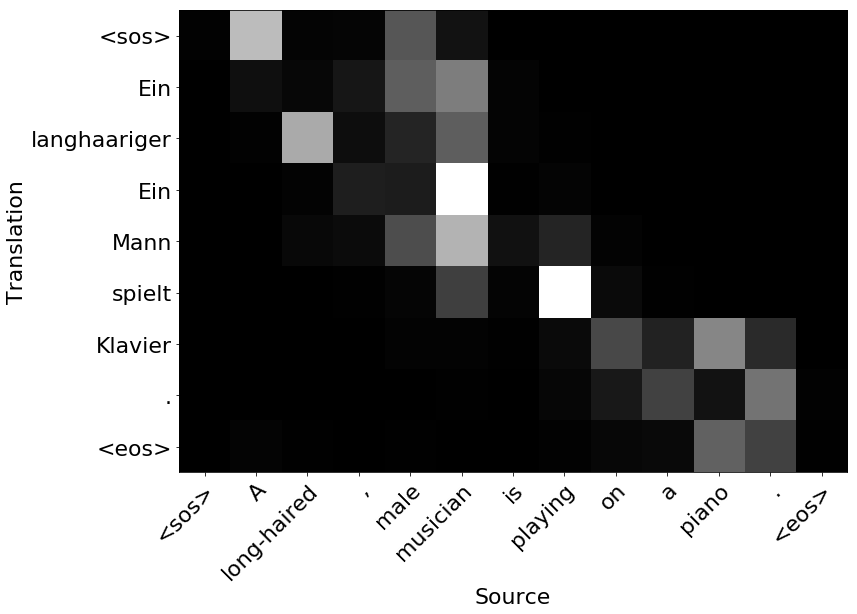

In [28]:
_, translations, attention_weights = evaluate_batch(config_2, test_batch, True)
source_words = list(filter(lambda word: word != PAD_token, torch2words(source_language_2, test_batch_src[:, 0])))
translation_words = list(filter(lambda word: word != PAD_token, list2words(target_language_2, translations[0])))
attention_weights = attention_weights.numpy()
n = len(source_words)
m = len(translation_words)
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(n, m))
ax.imshow(attention_weights, cmap='gray')
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(m))
ax.set_xticklabels(source_words)
ax.set_yticklabels(translation_words)
ax.set_xlabel('Source')
ax.set_ylabel('Translation')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.tight_layout()
plt.show()

# Learning Curves

In [14]:
train_loss = pd.read_csv(f'model-data/final/train-loss.csv')
val_loss = pd.read_csv(f'model-data/final/val-loss.csv')
val_bleu = pd.read_csv(f'model-data/final/bleu.csv')
train_xs = train_loss['Step'].values
train_loss = train_loss['Value'].values
val_xs = val_loss['Step'].values
val_loss = val_loss['Value'].values
val_bleu = val_bleu['Value'].values

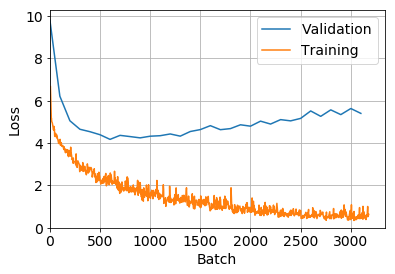

In [36]:
plt.figure()
plt.rcParams.update({'font.size': 14})
plt.plot(val_xs, val_loss, label='Validation')
plt.plot(train_xs, train_loss, label='Training')
plt.grid()
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

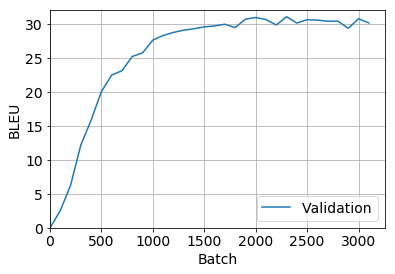

In [38]:
plt.figure()
plt.rcParams.update({'font.size': 14})
plt.plot(val_xs, val_bleu, label='Validation')
plt.grid()
plt.xlim(left=0)
plt.ylim(bottom=0, top=32)
plt.xlabel('Batch')
plt.ylabel('BLEU')
plt.legend()
plt.show()